In [0]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
import numpy as np

In [0]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf

In [0]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 50
l = 40
num_filter = 12
compression = 0.5
compression_1 = 2
compression_2 = 4
dropout_rate = 0.2

In [4]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

170500096/170498071 [==============================] - 11s 0us/step


In [0]:
X_train=X_train.astype("float32")  
X_test=X_test.astype("float32")
mean=np.mean(X_train)
std=np.std(X_train)
X_test=(X_test-mean)/std
X_train=(X_train-mean)/std

In [6]:
X_train.shape

(50000, 32, 32, 3)

In [7]:
X_test.shape

(10000, 32, 32, 3)

Image Augmentation 

In [8]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.3, height_shift_range=0.3, horizontal_flip=True,rotation_range=15)
datagen.fit(X_train)
img_train = datagen.flow(X_train, y_train, batch_size=64)
steps = int(X_train.shape[0] / 64)

Using TensorFlow backend.


Kernel of size 3x3 running for 50 epochs

In [0]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    global compression_1
    global compression_2
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        #if dropout_rate>0:
            #Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Block
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    #if dropout_rate>0:
         #Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    #flat = layers.Flatten()(AvgPooling)
    First = layers.Conv2D(int(10), (2,2), use_bias=False ,padding='same')(AvgPooling)
    Maxpool = layers.GlobalMaxPooling2D()(First)
    output = layers.Activation("softmax")(Maxpool)
    return output

In [0]:
num_filter = 12
dropout_rate = 0.2
l = 12
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

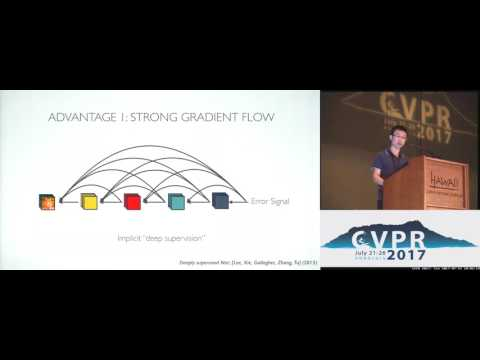

In [11]:
#https://arxiv.org/pdf/1608.06993.pdf
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo(id='-W6y8xnd--U', width=600)

In [12]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 12)   324         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 12)   48          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 12)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
#https://www.tensorflow.org/tensorboard/scalars_and_keras
filepath="weights.best.hdf5"
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
callback_1 = tf.keras.callbacks.ModelCheckpoint(filepath=filepath ,
                                save_weights_only=True,
                                monitor="val_accuracy",
                                mode="max",
                                save_best_only=True,
                                verbose=1)
tensorboard_1 = TensorBoard(log_dir='graph_one', batch_size=16,update_freq='epoch')

/usr/local/lib/python3.6/dist-packages/keras/callbacks/tensorboard_v2.py:92: UserWarning: The TensorBoard callback `batch_size` argument (for histogram computation) is deprecated with TensorFlow 2.0. It will be ignored.
  warnings.warn('The TensorBoard callback `batch_size` argument '


In [0]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [15]:
history = model.fit_generator(img_train,
                    steps_per_epoch=steps,
                    epochs=epochs,
                    verbose=1, 
                    validation_data=(X_test, y_test),
                    callbacks=callback_1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
781/781 [==============================] - ETA: 0s - loss: 1.7687 - accuracy: 0.3304
Epoch 00001: val_accuracy improved from -inf to 0.39300, saving model to weights.best.hdf5
781/781 [==============================] - 125s 159ms/step - loss: 1.7687 - accuracy: 0.3304 - val_loss: 1.7819 - val_accuracy: 0.3930
Epoch 2/50
781/781 [==============================] - ETA: 0s - loss: 1.4507 - accuracy: 0.4648
Epoch 00002: val_accuracy improved from 0.39300 to 0.46300, saving model to weights.best.hdf5
781/781 [==============================] - 120s 154ms/step - loss: 1.4507 - accuracy: 0.4648 - val_loss: 1.5547 - val_accuracy: 0.4630
Epoch 3/50
781/781 [==============================] - ETA: 0s - loss: 1.3097 - accuracy: 0.5259
Epoch 00003: val_accuracy improved from 0.46300 to 0.50360, saving model to weights.best.hdf5
781/781 [==============================] - 120s 154ms/step - loss: 1.3097 - accuracy: 0

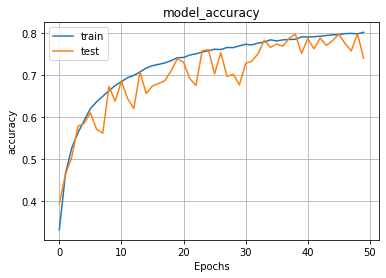

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid()
plt.title('model_accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model.h5")
print("Saved model to disk")

Saved model to disk


In [18]:
# Test the model
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 8s 26ms/step - loss: 0.8045 - accuracy: 0.7401
Test loss: 0.8045022487640381
Test accuracy: 0.7401000261306763


Model 2

In [0]:
#https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/
from keras.preprocessing.image import ImageDataGenerator

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.3, height_shift_range=0.3, horizontal_flip=True,rotation_range=15)
datagen.fit(X_train)
it_train = datagen.flow(X_train, y_train, batch_size=64)
steps = int(X_train.shape[0] / 64)

In [0]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 100
l = 40
num_filter = 24
compression = 0.5
compression_1 = 2
compression_2 = 4
dropout_rate = 0.2

In [0]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    global compression_1
    global compression_2
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        #if dropout_rate>0:
            #Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Block
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    #if dropout_rate>0:
         #Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    #flat = layers.Flatten()(AvgPooling)
    First = layers.Conv2D(int(10), (2,2), use_bias=False ,padding='same')(AvgPooling)
    Maxpool = layers.GlobalMaxPooling2D()(First)
    output = layers.Activation("softmax")(Maxpool)
    return output

In [0]:
num_filter = 24
dropout_rate = 0.2
l = 12
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [13]:
model_2 = Model(inputs=[input], outputs=[output])
model_2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 24)   648         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 24)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 24)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
#https://www.tensorflow.org/tensorboard/scalars_and_keras
filepath="weights_3.best.hdf5"
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
callback_2 = tf.keras.callbacks.ModelCheckpoint(filepath=filepath ,
                                save_weights_only=True,
                                monitor="val_accuracy",
                                mode="max",
                                save_best_only=True,
                                verbose=1)
tensorboard_2 = TensorBoard(log_dir='graph_one', batch_size=64,update_freq='epoch')

/usr/local/lib/python3.6/dist-packages/keras/callbacks/tensorboard_v2.py:92: UserWarning: The TensorBoard callback `batch_size` argument (for histogram computation) is deprecated with TensorFlow 2.0. It will be ignored.
  warnings.warn('The TensorBoard callback `batch_size` argument '


In [0]:
# determine Loss function and Optimizer
model_2.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [16]:
history = model_2.fit_generator(img_train,
                    steps_per_epoch=steps,
                    epochs=epochs,
                    verbose=1, 
                    validation_data=(X_test, y_test),
                    callbacks=callback_2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
781/781 [==============================] - ETA: 0s - loss: 1.7078 - accuracy: 0.3614
Epoch 00001: val_accuracy improved from -inf to 0.48190, saving model to weights_3.best.hdf5
781/781 [==============================] - 64s 82ms/step - loss: 1.7078 - accuracy: 0.3614 - val_loss: 1.4209 - val_accuracy: 0.4819
Epoch 2/100
781/781 [==============================] - ETA: 0s - loss: 1.3442 - accuracy: 0.5120
Epoch 00002: val_accuracy did not improve from 0.48190
781/781 [==============================] - 60s 77ms/step - loss: 1.3442 - accuracy: 0.5120 - val_loss: 1.9366 - val_accuracy: 0.4339
Epoch 3/100
781/781 [==============================] - ETA: 0s - loss: 1.1557 - accuracy: 0.5852
Epoch 00003: val_accuracy improved from 0.48190 to 0.62060, saving model to weights_3.best.hdf5
781/781 [==============================] - 61s 78ms/step - loss: 1.1557 - accuracy: 0.5852 - val_loss: 1.0709 - val_accurac

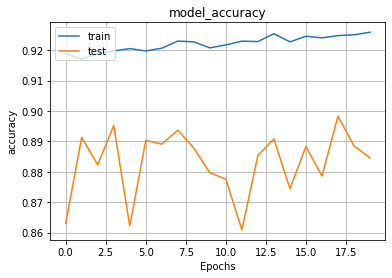

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid()
plt.title('model_accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model_2.load_weights("weights_3.best.hdf5")

In [0]:
model_2.compile(
loss='categorical_crossentropy',
optimizer=Adam(),
metrics=['accuracy'])

In [21]:
# Test the model
score = model_2.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 4s 11ms/step - loss: 0.3292 - accuracy: 0.8983
Test loss: 0.32916033267974854
Test accuracy: 0.8982999920845032


Training for 20 more epochs for Better Accuracy

In [23]:
history = model_2.fit_generator(img_train,
                    steps_per_epoch=steps,
                    epochs=20,
                    verbose=1, 
                    validation_data=(X_test, y_test),
                    callbacks=callback_2)

781/781 [==============================] - ETA: 0s - loss: 0.1997 - accuracy: 0.9312
Epoch 00013: val_accuracy did not improve from 0.90280
781/781 [==============================] - 60s 77ms/step - loss: 0.1997 - accuracy: 0.9312 - val_loss: 0.4479 - val_accuracy: 0.8747

Epoch 00013: val_accuracy did not improve from 0.90280
781/781 [==============================] - 60s 77ms/step - loss: 0.1997 - accuracy: 0.9312 - val_loss: 0.4479 - val_accuracy: 0.8747
Epoch 14/20
781/781 [==============================] - ETA: 0s - loss: 0.1958 - accuracy: 0.9304
Epoch 00014: val_accuracy did not improve from 0.90280
781/781 [==============================] - 60s 76ms/step - loss: 0.1958 - accuracy: 0.9304 - val_loss: 0.3857 - val_accuracy: 0.8926

Epoch 00014: val_accuracy did not improve from 0.90280
781/781 [==============================] - 60s 76ms/step - loss: 0.1958 - accuracy: 0.9304 - val_loss: 0.3857 - val_accuracy: 0.8926
Epoch 15/20
781/781 [==============================] - ETA: 0s -

In [0]:
model_2.load_weights("weights_3.best.hdf5")

In [25]:
# Test the model
score = model_2.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 4s 11ms/step - loss: 0.3397 - accuracy: 0.9028
Test loss: 0.3396528363227844
Test accuracy: 0.9028000235557556


In [27]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "kernel", "filters", "Train Accuracy(%)", "Test accuracy(%)"]
x.add_row(["Model 1", "3x3", 12, 80.19, 74.01]),
x.add_row(["Model 2", "3x3", 24, 93.13,90.28]),

print(x)

+---------+--------+---------+-------------------+------------------+
|  Model  | kernel | filters | Train Accuracy(%) | Test accuracy(%) |
+---------+--------+---------+-------------------+------------------+
| Model 1 |  3x3   |    12   |       80.19       |      74.01       |
| Model 2 |  3x3   |    24   |       93.13       |      90.28       |
+---------+--------+---------+-------------------+------------------+
